<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_19_Mindlin_plate_in_bending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

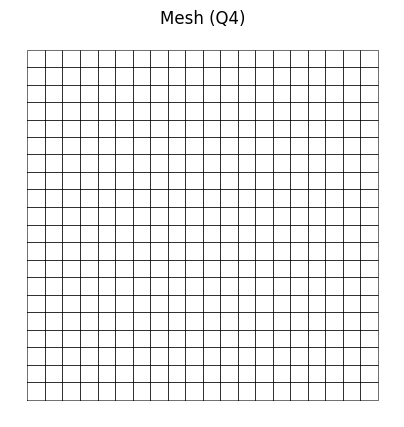

Displacements (DOF, value)
   1   0.000000000000e+00
   2   0.000000000000e+00
   3   0.000000000000e+00
   4   0.000000000000e+00
   5   0.000000000000e+00
   6   0.000000000000e+00
   7   0.000000000000e+00
   8   0.000000000000e+00
   9   0.000000000000e+00
  10   0.000000000000e+00
  11   0.000000000000e+00
  12   0.000000000000e+00
  13   0.000000000000e+00
  14   0.000000000000e+00
  15   0.000000000000e+00
  16   0.000000000000e+00
  17   0.000000000000e+00
  18   0.000000000000e+00
  19   0.000000000000e+00
  20   0.000000000000e+00
  21   0.000000000000e+00
  22   0.000000000000e+00
  23  -1.259725836687e-04
  24  -2.424527231741e-04
  25  -3.486367590081e-04
  26  -4.428361853690e-04
  27  -5.240149475361e-04
  28  -5.913074011391e-04
  29  -6.441590696966e-04
  30  -6.821539659499e-04
  31  -7.050499640419e-04
  32  -7.126937846924e-04
  33  -7.050499640419e-04
  34  -6.821539659499e-04
  35  -6.441590696966e-04
  36  -5.913074011391e-04
  37  -5.240149475361e-04
  38  -4.42

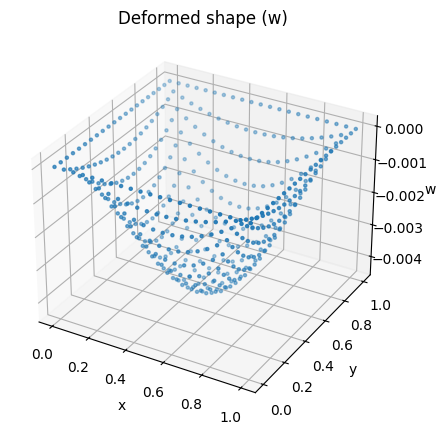


min(w) = -0.004270398771439612
min(w)*D1/L^4 = -0.004270398771439613


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# Q4 utilities (same definitions as in the book)
# ============================================================
def gaussQuadrature(option='complete'):
    if option == 'complete':  # 2x2
        a = 0.577350269189626
        locations = np.array([
            [-a, -a],
            [ a, -a],
            [ a,  a],
            [-a,  a]
        ], dtype=float)
        weights = np.array([1, 1, 1, 1], dtype=float)
    elif option == 'reduced':  # 1x1
        locations = np.array([[0.0, 0.0]], dtype=float)
        weights = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return weights, locations


def shapeFunctionQ4(xi, eta):
    # shape functions
    N = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta)
    ], dtype=float)

    # natural derivatives (rows=node 1..4, cols=[d/dxi, d/deta])
    dN = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)]
    ], dtype=float)
    return N, dN


def Jacobian(nodeCoords_elem, naturalDerivatives):
    # MATLAB: JacobianMatrix = nodeCoordinates' * naturalDerivatives
    J = nodeCoords_elem.T @ naturalDerivatives  # (2x4)(4x2)->(2x2)
    invJ = np.linalg.inv(J)
    XYderivatives = naturalDerivatives @ invJ   # (4x2)
    return J, invJ, XYderivatives


def rectangularMesh(Lx, Ly, nEx, nEy):
    xs = np.linspace(0.0, Lx, nEx + 1)
    ys = np.linspace(0.0, Ly, nEy + 1)
    X, Y = np.meshgrid(xs, ys)
    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def nid(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elementNodes = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = nid(ix,   iy)
            n2 = nid(ix+1, iy)
            n3 = nid(ix+1, iy+1)
            n4 = nid(ix,   iy+1)
            elementNodes.append([n1, n2, n3, n4])

    return nodeCoordinates, np.array(elementNodes, dtype=int)


def drawingMesh(nodeCoordinates, elementNodes, ax=None, lw=0.6):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    for elem in elementNodes:
        ids = elem.astype(int) - 1
        poly = np.vstack([nodeCoordinates[ids, :], nodeCoordinates[ids[0], :]])
        ax.plot(poly[:, 0], poly[:, 1], 'k-', lw=lw)
    ax.set_aspect('equal', 'box')
    return ax


# ============================================================
# EssentialBC for Mindlin plate (from screenshot)
# DOF order:
#   w  : 1..N
#   tx : N+1..2N
#   ty : 2N+1..3N
# ============================================================
def EssentialBC(typeBC, GDoF, xx, yy, nodeCoordinates, numberNodes):
    xmin, xmax = np.min(nodeCoordinates[:, 0]), np.max(nodeCoordinates[:, 0])
    ymin, ymax = np.min(nodeCoordinates[:, 1]), np.max(nodeCoordinates[:, 1])

    # 1-based node ids on edges
    on_left   = np.where(np.isclose(xx, xmin))[0] + 1
    on_right  = np.where(np.isclose(xx, xmax))[0] + 1
    on_bottom = np.where(np.isclose(yy, ymin))[0] + 1
    on_top    = np.where(np.isclose(yy, ymax))[0] + 1

    edges_all = np.unique(np.hstack([on_left, on_right, on_bottom, on_top]))

    typeBC = typeBC.lower()

    if typeBC == 'ssss':
        # fixedNodeW = all edges
        fixedNodeW = edges_all
        # fixedNodeTX = y edges (top & bottom)
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        # fixedNodeTY = x edges (left & right)
        fixedNodeTY = np.unique(np.hstack([on_left, on_right]))

    elif typeBC == 'cccc':
        fixedNodeW  = edges_all
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif typeBC == 'cccf':
        # screenshot: w fixed on x=min and y=min/y=max
        fixedNodeW  = np.unique(np.hstack([on_left, on_bottom, on_top]))
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif typeBC == 'scsc':
        # keep a sensible interpretation:
        # w fixed on all edges; rotations: clamp on y-edges (top/bottom) for tx; leave ty free except a pin to remove rigid mode
        fixedNodeW  = edges_all
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedNodeTY = np.array([1], dtype=int)  # small constraint like many textbook codes

    else:
        raise ValueError("typeBC must be one of: 'ssss','cccc','cccf','scsc'")

    prescribedDof = np.unique(np.hstack([
        fixedNodeW,
        fixedNodeTX + numberNodes,
        fixedNodeTY + 2*numberNodes
    ])).astype(int)

    allDof = np.arange(1, GDoF + 1, dtype=int)
    activeDof = np.setdiff1d(allDof, prescribedDof)

    return prescribedDof, activeDof, fixedNodeW


# ============================================================
# Mindlin plate stiffness assembly (MATCH screenshot matrices)
# ============================================================
def formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, C_shear, C_bending, thickness, I):
    K = np.zeros((GDoF, GDoF), dtype=float)

    # ---- bending: complete (2x2)
    gw_b, gl_b = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :]            # 1-based (4 nodes)
        nodes = indice.astype(int) - 1         # 0-based
        ndof = len(indice)                     # 4

        # elementDof = [indice  indice+N  indice+2N]
        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_b)):
            xi, eta = gl_b[q, 0], gl_b[q, 1]
            wt = gw_b[q]

            shapeFunction, naturalDerivatives = shapeFunctionQ4(xi, eta)
            Jacob, invJ, XYderivatives = Jacobian(nodeCoordinates[nodes, :], naturalDerivatives)
            detJ = np.linalg.det(Jacob)

            # B_b (3 x 3*ndof) as in screenshot
            B_b = np.zeros((3, 3*ndof), dtype=float)
            # B_b(1,ndof+1:2*ndof) = d()/dx
            B_b[0, ndof:2*ndof] = XYderivatives[:, 0]
            # B_b(2,2*ndof+1:3*ndof) = d()/dy
            B_b[1, 2*ndof:3*ndof] = XYderivatives[:, 1]
            # B_b(3,ndof+1:2*ndof) = d()/dy
            B_b[2, ndof:2*ndof] = XYderivatives[:, 1]
            # B_b(3,2*ndof+1:3*ndof) = d()/dx
            B_b[2, 2*ndof:3*ndof] = XYderivatives[:, 0]

            K[np.ix_(elementDof, elementDof)] += (B_b.T @ C_bending @ B_b) * wt * detJ

    # ---- shear: reduced (1x1)
    gw_s, gl_s = gaussQuadrature('reduced')

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_s)):
            xi, eta = gl_s[q, 0], gl_s[q, 1]
            wt = gw_s[q]

            shapeFunction, naturalDerivatives = shapeFunctionQ4(xi, eta)
            Jacob, invJ, XYderivatives = Jacobian(nodeCoordinates[nodes, :], naturalDerivatives)
            detJ = np.linalg.det(Jacob)

            # B_s (2 x 3*ndof) as in screenshot
            B_s = np.zeros((2, 3*ndof), dtype=float)
            # gamma_xz = dw/dx + theta_x
            B_s[0, 0:ndof] = XYderivatives[:, 0]      # dw/dx
            B_s[0, ndof:2*ndof] = shapeFunction       # + theta_x
            # gamma_yz = dw/dy + theta_y
            B_s[1, 0:ndof] = XYderivatives[:, 1]      # dw/dy
            B_s[1, 2*ndof:3*ndof] = shapeFunction     # + theta_y

            K[np.ix_(elementDof, elementDof)] += (B_s.T @ C_shear @ B_s) * wt * detJ

    return K


# ============================================================
# Mindlin plate load vector (uniform pressure P) (reduced)
# force only on w-DOFs: force(indice) += N * P * detJ * wt
# ============================================================
def formForceVectorMindlinQ4(GDoF, numberElements, elementNodes, numberNodes, nodeCoordinates, P):
    F = np.zeros((GDoF,), dtype=float)
    gw, gl = gaussQuadrature('reduced')

    for e in range(numberElements):
        indice = elementNodes[e, :]           # 1-based
        nodes = indice.astype(int) - 1

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            wt = gw[q]

            shapeFunction, naturalDerivatives = shapeFunctionQ4(xi, eta)
            Jacob, invJ, XYderivatives = Jacobian(nodeCoordinates[nodes, :], naturalDerivatives)
            detJ = np.linalg.det(Jacob)

            # add to w DOFs only
            F[nodes] += shapeFunction * P * detJ * wt

    return F


def solution(GDoF, prescribedDof_1based, K, F):
    prescribed = np.array(prescribedDof_1based, dtype=int) - 1
    all_dofs = np.arange(GDoF)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros((GDoF,), dtype=float)
    U[free] = np.linalg.solve(K[np.ix_(free, free)], F[free])
    U[prescribed] = 0.0
    return U


# ============================================================
# MAIN (Mindlin plate in bending) — matches your screenshots
# ============================================================
plt.rcParams['figure.facecolor'] = 'white'

# materials
E = 10920.0
poisson = 0.30
kapa = 5/6
thickness = 0.1
I = thickness**3 / 12.0

# bending matrix
C_bending = (I * E / (1 - poisson**2)) * np.array([
    [1, poisson, 0],
    [poisson, 1, 0],
    [0, 0, (1 - poisson)/2]
], dtype=float)

# shear matrix
C_shear = (kapa * thickness * E / 2.0 / (1 + poisson)) * np.eye(2)

# load
P = -1.0

# mesh
L = 1.0
numberElementsX = 20
numberElementsY = 20
numberElements = numberElementsX * numberElementsY

nodeCoordinates, elementNodes = rectangularMesh(L, L, numberElementsX, numberElementsY)
xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]
numberNodes = nodeCoordinates.shape[0]

# draw mesh
fig, ax = plt.subplots(figsize=(5, 5))
drawingMesh(nodeCoordinates, elementNodes, ax=ax, lw=0.4)
ax.set_title("Mesh (Q4)")
ax.axis('off')
plt.show()

# DOF
GDoF = 3 * numberNodes

# stiffness & force
K = formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, C_shear, C_bending, thickness, I)

F = formForceVectorMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                             nodeCoordinates, P)

# boundary conditions
prescribedDof, activeDof, fixedNodeW = EssentialBC('ssss', GDoF, xx, yy, nodeCoordinates, numberNodes)

# solve
U = solution(GDoF, prescribedDof, K, F)

# output displacements (like MATLAB: node U)
print("Displacements (DOF, value)")
for i in range(GDoF):
    print(f"{i+1:4d}  {U[i]: .12e}")

# deformed shape: plot3(xx,yy,w,'.')
w = U[:numberNodes]

fig = plt.figure(figsize=(7, 5))
ax3 = fig.add_subplot(111, projection='3d')
ax3.scatter(xx, yy, w, s=5)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('w')
ax3.set_title("Deformed shape (w)")
plt.show()

# nondimensional check (matches book snippet idea)
D1 = E * thickness**3 / 12.0 / (1 - poisson**2)
print("\nmin(w) =", np.min(w))
print("min(w)*D1/L^4 =", np.min(w) * D1 / (L**4))
